In [2]:
import argparse
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pycircstat.descriptive as circstat
%matplotlib inline

/Users/richardknoche/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/richardknoche/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


# Is the image gray

In [2]:
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Contrast/HighContrast2.jpg')
I_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
I_h = I_hsv[:,:,0]
I_h_rad = I_h.flatten()*np.pi/180.0
I_s = I_hsv[:,:,1]
np.all(I_s==0)

True

# RGB Mean and Std

In [3]:
(means, stds) = cv2.meanStdDev(image)
b_mean,g_mean,r_mean=means[:,0]
b_std,g_std,r_std=stds[:,0]/means[:,0] #normalized to mean


# Color Gradients

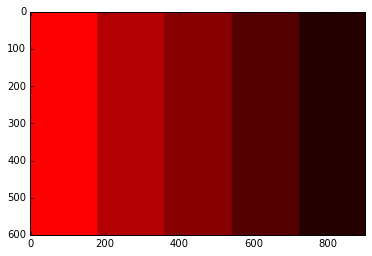

In [4]:
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Color/Gradient2.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


In [5]:
b=image[:,:,0]
g=image[:,:,1]
r=image[:,:,2]

r_xgrad = np.mean(cv2.Sobel(r,cv2.CV_64F,1,0,ksize=1))
g_xgrad = np.mean(cv2.Sobel(g,cv2.CV_64F,1,0,ksize=1))
b_xgrad = np.mean(cv2.Sobel(b,cv2.CV_64F,1,0,ksize=1))

r_ygrad = np.mean(cv2.Sobel(r,cv2.CV_64F,0,1,ksize=1))
g_ygrad = np.mean(cv2.Sobel(g,cv2.CV_64F,0,1,ksize=1))
b_ygrad = np.mean(cv2.Sobel(b,cv2.CV_64F,0,1,ksize=1))


r_xgrad_std = np.std(cv2.Sobel(r,cv2.CV_64F,1,0,ksize=1))
g_xgrad_std = np.std(cv2.Sobel(g,cv2.CV_64F,1,0,ksize=1))
b_xgrad_std = np.std(cv2.Sobel(b,cv2.CV_64F,1,0,ksize=1))

r_ygrad_std = np.std(cv2.Sobel(r,cv2.CV_64F,0,1,ksize=1))
g_ygrad_std = np.std(cv2.Sobel(g,cv2.CV_64F,0,1,ksize=1))
b_ygrad_std = np.std(cv2.Sobel(b,cv2.CV_64F,0,1,ksize=1))

# Image entropy/constrast (works well, but slow)

In [6]:
from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk

6.86004251372


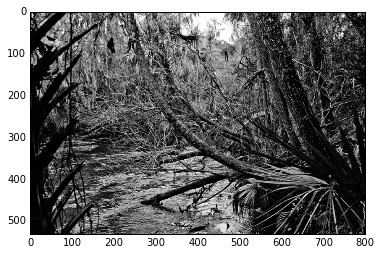

In [7]:
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Contrast/HighContrast1.jpg')
scaler = np.min([800.0/image.shape[0], 800.0/image.shape[1]])
image = cv2.resize(image,(np.int(scaler*image.shape[1]),np.int(scaler*image.shape[0])),interpolation=cv2.INTER_AREA)

entr_img = entropy(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), disk(7))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print(entr_img.max())

# Image greyscale contrast (doesn't work well)

72.2957600212


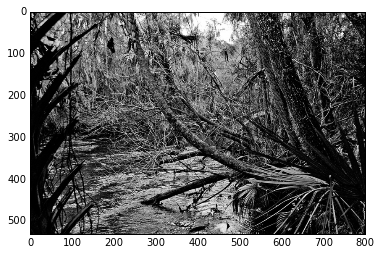

In [8]:
import scipy.signal

image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Contrast/HighContrast1.jpg')
scaler = np.min([800.0/image.shape[0], 800.0/image.shape[1]])
image = cv2.resize(image,(np.int(scaler*image.shape[1]),np.int(scaler*image.shape[0])),interpolation=cv2.INTER_AREA)

#convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')

#Do the below for the original image, then the super pixels (4->1)
resolutions = [1,2,4,8,16,25,50,100,200]

#Calculate constraint for each resolution
local_cs = np.array([])
for scale_factor in resolutions:
    scaled_gray = cv2.resize(gray,( int(gray.shape[1]/200),int(gray.shape[0]/200)))

    #calculate luminace of each pixel
    l = 100*np.sqrt( (gray/255)*2.2 )

    neighbors=[[0,1,0],[1,0,1],[0,1,0]]
    neighbor_sum = scipy.signal.convolve2d(l, neighbors, mode='same')
    neighbor_counts = scipy.signal.convolve2d(np.ones_like(l), neighbors, mode='same')

    local_l = neighbor_sum/neighbor_counts
    local_cs = np.append(local_cs,local_l.mean())


global_cs= np.array([ ( (-0.406385*( (idx+1)/9) +0.334573)*( (idx+1)/9) + 0.0877526)*con for (idx,con) in enumerate(local_cs)]).sum()
print(global_cs)


# HSV Color Features

In [9]:
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Blur/Sharp/Couch3.jpg')
I_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
I_h = I_hsv[:,:,0]
I_s = I_hsv[:,:,1]
I_v = I_hsv[:,:,2]
I_g = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

H_mean = circstat.mean(I_h_rad)*180.0/np.pi           
H_var  = circstat.var(I_h_rad)*180.0/np.pi

S_mean = np.mean(I_s)/255.0                           
S_var  = np.var(I_s/255.0)

V_mean = np.mean(I_v)/255.0                           
V_var  = np.var(I_v/255.0)

Lapacian_Hue        = cv2.Laplacian(I_h/255.0, cv2.CV_64F).var()
Lapacian_Saturation = cv2.Laplacian(I_s/255.0, cv2.CV_64F).var()
Lapacian_Value     = cv2.Laplacian(I_v/255.0, cv2.CV_64F).var()



# Complementary Colors

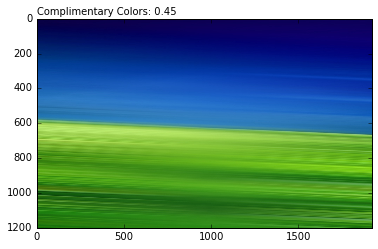

In [17]:
#Hue goes from 0 -> 360 degrees
#Complementary colors are opposite each other
#0 and 180 are complementary
#0 and 90 are not complementary
##exp^(theta*i) gives the (x,y) coords on the unit circle in complex plane
#We want 0 and 180 to add together, and 0 and 90 to cancel out. Then the higher the number, the better
#Achieve this by multiplying angle by 2 so 0-> and 180->360, and 90->180, etc
#The maximum possible value is then if all align, so len(I_h.flatten())
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Color/Uncomplimentary.jpg')

#image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Blur/Sharp/Couch2.jpg')
I_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
I_h = I_hsv[:,:,0]
I_s = I_hsv[:,:,1]
I_v = I_hsv[:,:,2]
I_g = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)


I_h_rad = I_h.flatten()*(np.pi/180.0) #convert to radians
complimentary_index = np.abs(np.exp(2*I_h_rad*1j).sum() / len(I_h.flatten())) #ranges from 0 to 1, 1 is more complementary
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax = plt.gca()
ax.text(0,-20,'Complimentary Colors: %0.2f' %complimentary_index)

# Saliency

In [11]:
#What is a saliency map: http://www.scholarpedia.org/article/Saliency_map
#Have to be reshaped ahead of time.. otherwise run into issues
import pySaliencyMap as SMap
for folder in ('Blurry','Sharp'):
    print('---- '+folder+' ----')
    for i in range(1,6,1):
        image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Blur/'+folder+'/Couch'+str(i)+'.jpg')
        scaler = np.min([800.0/image.shape[0], 800.0/image.shape[1]])
        image = cv2.resize(image,(np.int(scaler*image.shape[1]),np.int(scaler*image.shape[0])),interpolation=cv2.INTER_AREA)

        sm = SMap.pySaliencyMap(image.shape[1], image.shape[0])
        saliencymap    = sm.SMGetSM(image)
        Salience_mean  = np.mean(saliencymap)     # 0-1
        Salience_med   = np.median(saliencymap)   # 0-1
        Salience_var   = np.var(saliencymap)      # 0-1
        plt.imshow(saliencymap,cmap='gray')
        print(Salience_mean)

ImportError: No module named 'pySaliencyMap'

# Salient Features

In [ ]:
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Blur/Sharp/Couch2.jpg')
scaler = np.min([800.0/image.shape[0], 800.0/image.shape[1]])
image = cv2.resize(image,(np.int(scaler*image.shape[1]),np.int(scaler*image.shape[0])),interpolation=cv2.INTER_AREA)
sm = SMap.pySaliencyMap(image.shape[1], image.shape[0])
saliencymap    = sm.SMGetSM(image)
I_hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
I_h = I_hsv[:,:,0]
I_s = I_hsv[:,:,1]
I_v = I_hsv[:,:,2]
I_g = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

In [12]:
#What does HSV look like at the focal points of high saliency, compared to image average

Saliency_Thresh = 0.2
Salient_Hue = np.log(circstat.mean(I_h[saliencymap>=Saliency_Thresh]*np.pi/180.0)/circstat.mean(I_h*np.pi/180.0))
Salient_Saturation = np.log(np.mean(I_s[saliencymap>=Saliency_Thresh])/np.mean(I_s))
Salient_Value = np.log(np.mean(I_v[saliencymap>=Saliency_Thresh])/np.mean(I_v))

print(Salient_Hue)
print(Salient_Saturation)
print(Salient_Value)

NameError: name 'saliencymap' is not defined

# Colorfulness - Method One

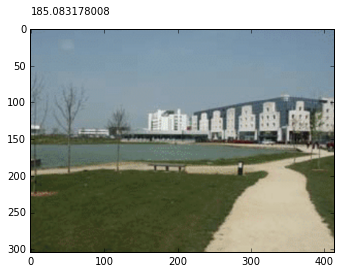

In [19]:
#DOESNT SEEM TO BE WORKING
#From https://www.researchgate.net/publication/278101225_Colorfulness_of_the_image_definition_computation_and_properties_-_art_no_615805
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Color/ColorTest5.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


#Image Format is BGR
b,g,r = cv2.split(image)

rg = r - g
yb = 0.5*(r+g) - b

Srgyb = np.sqrt(rg.var() + yb.var())
Mrgyb = np.sqrt(rg.mean()**2 + yb.mean()**2)
colorfulness = Srgyb + 0.3*Mrgyb
ax = plt.gca()
ax.text(0,-20,'Colorfulness: ', colorfulness)

# Colorfullness - Method Two

In [ ]:
#APPROACH TWO -- AREA OF AB SPACE

#From https://www.researchgate.net/publication/278101225_Colorfulness_of_the_image_definition_computation_and_properties_-_art_no_615805

image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Color/ColorTest1.png')
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)
plt.scatter(a_channel,b_channel,s=2,color='r')


image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Color/ColorTest5.png')
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)
plt.scatter(a_channel,b_channel,s=2,color='b')


image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Color/ColorTest3.png')
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)
plt.scatter(a_channel,b_channel,s=2,color='k')

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

def PolygonArea(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area


In [ ]:
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Blur/Sharp/Couch1.jpg')

#image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Color/ColorTest5.png')

lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)
coords = minimum_bounding_rectangle(np.stack([a_channel.flatten(),b_channel.flatten()],axis=1))
colorfulness = PolygonArea(coords)
points = ( (1,2), (5,4), (-1,-3) )
bounding_box = minimum_bounding_box(coords)  # returns namedtuple
bounding_box.area

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print(colorfulness)

# Colorfullness - Method Three

In [ ]:
#Using a polygon bounding box instead of rectangle (takes longer to compute)
from scipy.spatial import ConvexHull
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Blur/Sharp/Couch2.jpg')

#image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Color/ColorTest5.png')

lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)
points = np.stack([a_channel.flatten(),b_channel.flatten()],axis=1)
hull = ConvexHull(points)
colorfulness=hull.area

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print(colorfulness)



# Method 4

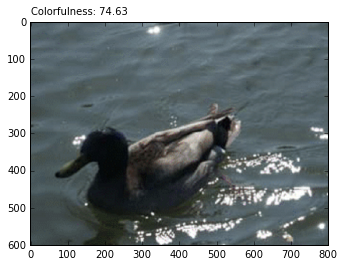

In [39]:
#From https://infoscience.epfl.ch/record/33994/files/HaslerS03.pdf
#image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Color/ColorTest3.png')
image = cv2.imread('/Users/richardknoche/Desktop/TestImages/Color/ColorTest3.png')
scaler = np.min([800.0/image.shape[0], 800.0/image.shape[1]])
image = cv2.resize(image,(np.int(scaler*image.shape[1]),np.int(scaler*image.shape[0])),interpolation=cv2.INTER_AREA)


plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l_channel,a_channel,b_channel = cv2.split(lab_image)

mu_ab = np.sqrt( a_channel.mean()**2 + b_channel.mean()**2)
c = a_channel.std() + b_channel.std() + 0.39*mu_ab
ax = plt.gca()
ax.text(0,-20,'Colorfulness: %0.2f'  % c)

In [27]:
image